In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from torchvision import models
from torchvision import transforms
from torchvision.io import read_image

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import random
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        
        self.device = device
        
        self.transform = transform

    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        if idx >= len(self): raise StopIteration

        img = read_image(self.df.loc[idx, 'img_path'])[:3,:,:]
        filename = self.df.loc[idx, 'filename']
        sign = self.df.loc[idx, 'sign']
        
        if self.transform:
            img = self.transform(img)

        return img, filename, sign
    
    def getData(self):
        return list(self)

In [6]:
def createDataFrame():
    
    train_df = pd.read_csv('../../data/train.csv')
    train_df['img_path'] = '../../data/avia-train/avia-train/' + train_df['filename'] + '.png'
    
    test_df = pd.read_csv('../../data/test.csv')
    test_df['img_path'] = '../../data/avia-test/avia-test/' + test_df['filename'] + '.png'
    test_df['sign'] = -1
    
    test_e_df = pd.read_csv('../../data/test_extended.csv', index_col='filename')
    
    test_e_df = test_e_df.drop(test_df['filename'])
    test_e_df['filename'] = test_e_df.index
    
    test_e_df['img_path'] = '../../data/avia-test-extended/avia-test-extended/' + test_e_df['filename'] + '.jpeg'
    test_e_df['sign'] = -1
    
    df = pd.concat((train_df, test_df, test_e_df)).reset_index(drop=True)
    
    df['sign'] = df['sign'].astype('float64')
    
    return df

In [7]:
def createDataLoader(df, batch_size=None, shuffle=False, transform=None):

    batch_size = batch_size if batch_size else len(df)
    
    dataset = CustomImageDataset(df, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    return dataset, dataloader

In [8]:
df = createDataFrame()

In [9]:
model = models.resnext50_32x4d(pretrained=True)

for param in list(model.parameters())[:-4]:
    param.require = False
    
model.fc = torch.nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)

weight = torch.tensor([sum(df['sign'] == 1) / sum(df['sign'] != -1)])
criterion = nn.BCELoss(weight=weight, reduction='mean')
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [10]:
%%time

def f():
    log = {'loss': {'train': [], 'val': []}, 'bestModel': None}
    
    epochs = 20
    
    train_df, val_df = train_test_split(df[df['sign'] != -1], test_size=0.2, random_state=42)
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    
    traintransform = transforms.Compose([
        transforms.ToPILImage(),

        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),

        transforms.ToTensor(),
    ])
    _, train_dataloader = createDataLoader(train_df, batch_size=100, shuffle=True, transform=traintransform)
    
    valTransform = transforms.Compose([
        transforms.ToPILImage(),

        transforms.ToTensor(),
    ])
    _, val_dataloader = createDataLoader(val_df, batch_size=100, shuffle=True, transform=valTransform)
    
    
    model.to(device)
    
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        for X, _, y in train_dataloader:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device).float().reshape(-1, 1)
            
            y_predict = model(X)

            loss = criterion(y_predict, y)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        log['loss']['train'].append(running_loss/len(train_dataloader))
        
        # Val
        model.eval()
        running_loss = 0
        for X, _, y in val_dataloader:

            X, y = X.to(device), y.to(device).float()

            y_predicted1 = model(X)
            y_predicted2 = model(transforms.RandomHorizontalFlip(p=1)(X))
            y_predicted3 = model(transforms.RandomVerticalFlip(p=1)(X))
            y_predicted4 = model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X)))

            y_predict = torch.cat((y_predicted1, y_predicted2, y_predicted3, y_predicted4), dim=1).mean(dim=1)

            loss = criterion(y_predict, y)
            running_loss += loss.item()


        log['loss']['val'].append(running_loss/len(val_dataloader))

        if not log['bestModel'] or log['loss']['val'][-1] < min(log['loss']['val'][:-1]):
            log['bestModel'] = model
            log['bestEpoch'] = epoch + 1

        print(f"Epoch: {epoch+1} / {epochs} | Train loss: {log['loss']['train'][-1]} | Val loss: {log['loss']['val'][-1]}")
            
    return log
        
log = f()    

Epoch: 1 / 20 | Train loss: 0.03490970318718069 | Val loss: 0.012550786610633607
Epoch: 2 / 20 | Train loss: 0.01417251724710531 | Val loss: 0.00808228270727254
Epoch: 3 / 20 | Train loss: 0.009770403342624476 | Val loss: 0.008941086973728878
Epoch: 4 / 20 | Train loss: 0.008844146953477716 | Val loss: 0.006877832406658738
Epoch: 5 / 20 | Train loss: 0.006764687177207111 | Val loss: 0.007454438657972903
Epoch: 6 / 20 | Train loss: 0.0067117027473172185 | Val loss: 0.007049890789425089
Epoch: 7 / 20 | Train loss: 0.0059493318966044725 | Val loss: 0.007800795871483546
Epoch: 8 / 20 | Train loss: 0.005353265181889787 | Val loss: 0.005967842360001264
Epoch: 9 / 20 | Train loss: 0.004931596990071151 | Val loss: 0.006218633155979674
Epoch: 10 / 20 | Train loss: 0.004407855513179301 | Val loss: 0.005722510949006334
Epoch: 11 / 20 | Train loss: 0.0043485888354370394 | Val loss: 0.005704983804626243
Epoch: 12 / 20 | Train loss: 0.0035525349934373133 | Val loss: 0.0054521359612293065
Epoch: 13 /

19


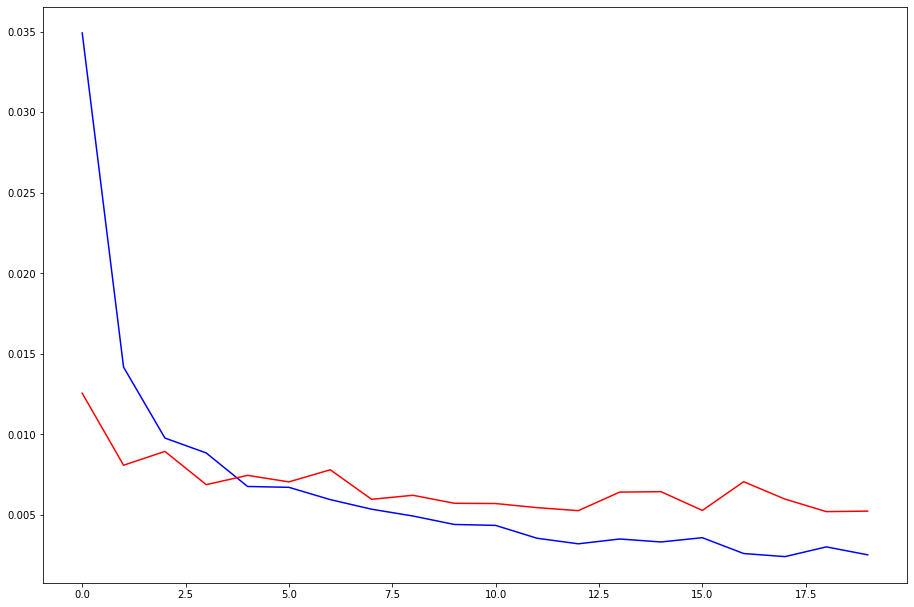

In [11]:
print(log['bestEpoch'])

fig = plt.figure()
axes = fig.add_axes([1, 1, 2, 2])

axes.plot(range(len(log['loss']['train'])), log['loss']['train'], 'b')
axes.plot(range(len(log['loss']['val'])), log['loss']['val'], 'r')
plt.show()

In [12]:
model = log['bestModel']

In [13]:
%%time
with torch.no_grad():
    model.eval()
    model.to(device)

    test_df = df.copy()
    test_df = test_df.reset_index(drop=True)
    
    testTransform = transforms.Compose([
        transforms.ToPILImage(),

        transforms.ToTensor(),
    ])
    _, test_dataloader = createDataLoader(test_df, batch_size=500, shuffle=True, transform=testTransform)
    
    filenames = []
    sign = []
    predicteds = [[], [], [], []]
    
    for X, filename, y in test_dataloader:

        X = X.to(device)
        
        predicteds[0].append(model(X).reshape(-1).cpu())
        predicteds[1].append(model(transforms.RandomHorizontalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[2].append(model(transforms.RandomVerticalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[3].append(model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X))).reshape(-1).cpu())
        
        sign.append(y)
        filenames += filename
        
predicteds[0] = torch.cat(predicteds[0], 0)
predicteds[1] = torch.cat(predicteds[1], 0)
predicteds[2] = torch.cat(predicteds[2], 0)
predicteds[3] = torch.cat(predicteds[3], 0)

sign = torch.cat(sign)

Wall time: 3min 9s


In [14]:
modelName = 'resnext50_32x4d'
filterName = 'None'

In [15]:
predict_df1 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'v': 0,
    
    'predict': predicteds[0],
    'sign': sign,
})

predict_df2 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'v': 1,
    
    'predict': predicteds[1],
    'sign': sign,
})

predict_df3 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'v': 2,
    
    'predict': predicteds[2],
    'sign': sign,
})

predict_df4 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'v': 3,
    
    'predict': predicteds[3],
    'sign': sign,
})

In [16]:
predict_df = pd.concat((predict_df1, predict_df2, predict_df3, predict_df4)).reset_index(drop=True)

In [17]:
predict_df

filename            model filter  v  \
0       3aad8951-0a04-46ca-8e44-54eaef528d28  resnext50_32x4d   None  0   
1       86f8d496-7450-4c8a-b8d2-19614066cd00  resnext50_32x4d   None  0   
2       18818624-8971-46fb-9a3b-3c450ac922e2  resnext50_32x4d   None  0   
3       a71c4bf8-7cc5-4695-927a-25413ce513de  resnext50_32x4d   None  0   
4       dca8c347-d04e-4495-9c2e-43731332fa76  resnext50_32x4d   None  0   
...                                      ...              ...    ... ..   
528315  69c53b5d-c40a-40c1-ad93-f72556750c55  resnext50_32x4d   None  3   
528316  fca8c5b7-33bb-41d8-ae82-ac026745ddfd  resnext50_32x4d   None  3   
528317  207941d3-2f46-4018-b89d-8d676e34cee0  resnext50_32x4d   None  3   
528318  9903acdd-051d-4f61-9e00-fb8971c56c38  resnext50_32x4d   None  3   
528319  522436bb-6fad-4b6f-8976-becd03f29652  resnext50_32x4d   None  3   

         predict  sign  
0       0.000004  -1.0  
1       0.000010  -1.0  
2       0.000003  -1.0  
3       0.000002  -1.0  
4       0.000004  -1.0  
...          ...   ...  
528315  0.000003  -1.0  
528316  0.000003  -1.0  
528317  0.000002  -1.0  
528318  0.000003  -1.0  
528319  0.000002  -1.0  

[528320 rows x 6 columns]

In [18]:
predict_df.to_csv(f'predicteds/{modelName}_{filterName}.csv', index=False)